In [1]:
!git clone https://github.com/marijal74/ml_pix2pix.git

Cloning into 'ml_pix2pix'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 168 (delta 94), reused 149 (delta 82), pack-reused 0
Receiving objects: 100% (168/168), 4.60 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [ ]:
!rm -r ml_pix2pix/

In [2]:
from ml_pix2pix.src.discriminator import Discriminator
from ml_pix2pix.src.generator import UNet
from ml_pix2pix.src import utils
from ml_pix2pix.src import losses
from ml_pix2pix.src.process_data import ImageDataset, Pix2PixDataset
from ml_pix2pix.src import process_data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import time
import multiprocessing

# Loading the Dataset

Using a custom class for loading a dataset using an enum.

In [3]:
pix2pix_dataset = Pix2PixDataset.FACADES
print("Which dataset:" + pix2pix_dataset.value)
print("Dataset url:" + pix2pix_dataset.get_url())
print("Batch size: {}, epochs: {}".format(pix2pix_dataset.batch_size(), pix2pix_dataset.num_epochs()))

Which dataset:facades
Dataset url:http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Pix2PixDataset.FACADES
Batch size: 1, epochs: 200


In [4]:
batch_size = pix2pix_dataset.batch_size()
epochs = pix2pix_dataset.num_epochs()

Pix2PixDataset.FACADES


Downloading the dataseet into `data` folder with `train`, `val` and `test` subfolders. All images are paired. `ImageDataset` class subclasses `pytorch.Dataset` class. When fetching a sample from a dataset, a sample is being preprocessed using transformations described in the original paper.

In [5]:
process_data.download_dataset(pix2pix_dataset)

Creating data folder


In [6]:
train_dataset = ImageDataset(pix2pix_dataset)
train_dataset.load_dataset()

In [7]:
print('Images in train dataset: {}'.format(train_dataset.__len__()))

Images in train dataset: 400


In [8]:
num_threads = multiprocessing.cpu_count()
print(f'Number of available threads:{num_threads}')

Number of available threads:2


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=num_threads)

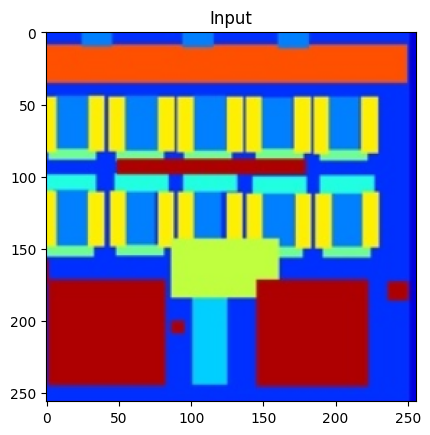

In [10]:
item = train_dataset.__getitem__(0)
plt.imshow(item[0].permute(1, 2, 0))
plt.title('Input')
plt.show()

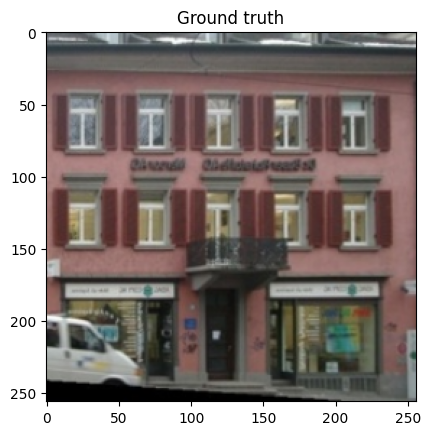

In [11]:
plt.imshow(item[1].permute(1, 2, 0))
plt.title('Ground truth')
plt.show()

# Creating the model

In [12]:
if (torch.cuda.is_available()):
  device = 'cuda'
  print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
  print(f"CUDA version: {torch.version.cuda}")

  # Storing ID of current CUDA device
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")

  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
else:
  device = 'cpu'
  print('No cuda available')



Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device:Tesla T4


In [13]:
print(device)

cuda


In [14]:
generator = UNet()
generator.eval()

UNet(
  (input): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [15]:
discriminator = Discriminator(num_channels = 3)
discriminator.eval()

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [16]:
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

# Training

In [17]:
inputs, targets = next(iter(train_dataloader))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [18]:
inputs.shape

torch.Size([1, 3, 256, 256])

In [19]:
disc_opt = losses.get_optimizer(discriminator.parameters())
gen_opt = losses.get_optimizer(generator.parameters())

In [20]:
disc_losses = []
gen_losses = []
num_of_steps = len(train_dataloader)

Epoch: 1


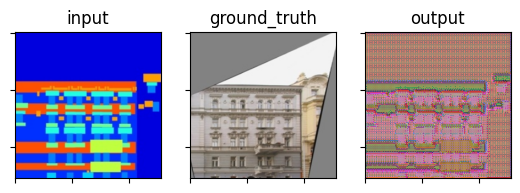

End of epoch 1 Time taken: 24.10724949836731
End of epoch 2 Time taken: 22.271214962005615
End of epoch 3 Time taken: 22.66508388519287
End of epoch 4 Time taken: 23.10873055458069
End of epoch 5 Time taken: 23.25581455230713
End of epoch 6 Time taken: 23.02109694480896
End of epoch 7 Time taken: 22.9619619846344
End of epoch 8 Time taken: 23.07685375213623
End of epoch 9 Time taken: 23.124958276748657
End of epoch 10 Time taken: 23.088008165359497
Epoch: 11


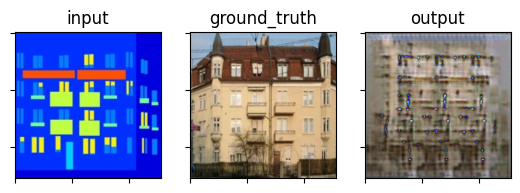

End of epoch 11 Time taken: 23.4059476852417
End of epoch 12 Time taken: 23.03823947906494
End of epoch 13 Time taken: 23.12576961517334
End of epoch 14 Time taken: 23.136316537857056
End of epoch 15 Time taken: 23.072989225387573
End of epoch 16 Time taken: 23.05087423324585
End of epoch 17 Time taken: 23.027496576309204
End of epoch 18 Time taken: 23.11648964881897
End of epoch 19 Time taken: 23.189547300338745
End of epoch 20 Time taken: 23.093836784362793
Epoch: 21


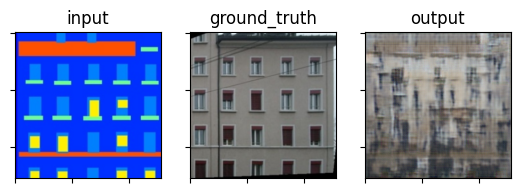

End of epoch 21 Time taken: 23.41264820098877
End of epoch 22 Time taken: 23.086997509002686
End of epoch 23 Time taken: 23.186537981033325
End of epoch 24 Time taken: 23.147998571395874
End of epoch 25 Time taken: 23.18201494216919
End of epoch 26 Time taken: 23.182557106018066
End of epoch 27 Time taken: 23.09457802772522
End of epoch 28 Time taken: 23.054575443267822
End of epoch 29 Time taken: 23.22552180290222
End of epoch 30 Time taken: 23.17648410797119
Epoch: 31


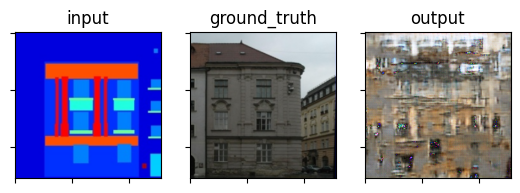

End of epoch 31 Time taken: 23.43692660331726
End of epoch 32 Time taken: 23.138179302215576
End of epoch 33 Time taken: 23.139400005340576
End of epoch 34 Time taken: 23.09117364883423
End of epoch 35 Time taken: 23.22306251525879
End of epoch 36 Time taken: 24.93593430519104
End of epoch 37 Time taken: 23.153839111328125
End of epoch 38 Time taken: 23.125356674194336
End of epoch 39 Time taken: 23.093804597854614
End of epoch 40 Time taken: 23.46504521369934
Epoch: 41


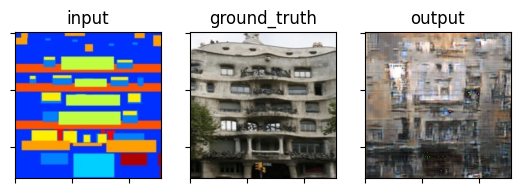

End of epoch 41 Time taken: 23.682031393051147
End of epoch 42 Time taken: 23.249380350112915
End of epoch 43 Time taken: 23.155893564224243
End of epoch 44 Time taken: 23.187594890594482
End of epoch 45 Time taken: 23.15639305114746
End of epoch 46 Time taken: 23.232353448867798
End of epoch 47 Time taken: 23.218942403793335
End of epoch 48 Time taken: 23.10413360595703
End of epoch 49 Time taken: 23.1900577545166
End of epoch 50 Time taken: 23.351467609405518
Epoch: 51


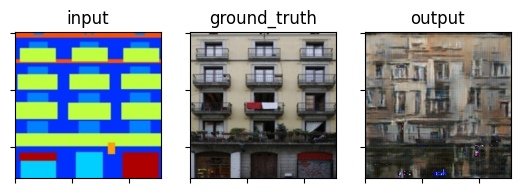

End of epoch 51 Time taken: 24.12563681602478
End of epoch 52 Time taken: 23.238773345947266
End of epoch 53 Time taken: 23.225603818893433
End of epoch 54 Time taken: 23.243074417114258
End of epoch 55 Time taken: 23.234437465667725
End of epoch 56 Time taken: 23.187639474868774
End of epoch 57 Time taken: 23.235229969024658
End of epoch 58 Time taken: 23.36539101600647
End of epoch 59 Time taken: 23.307689905166626
End of epoch 60 Time taken: 23.204822063446045
Epoch: 61


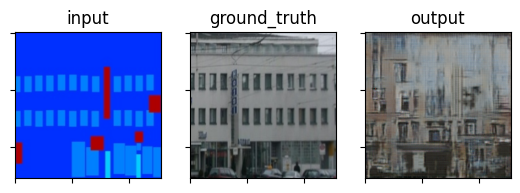

End of epoch 61 Time taken: 23.59032917022705
End of epoch 62 Time taken: 23.269058227539062
End of epoch 63 Time taken: 23.232959270477295
End of epoch 64 Time taken: 23.284276008605957
End of epoch 65 Time taken: 23.401526927947998
End of epoch 66 Time taken: 23.21339774131775
End of epoch 67 Time taken: 23.23174023628235
End of epoch 68 Time taken: 23.244478464126587
End of epoch 69 Time taken: 23.298537731170654
End of epoch 70 Time taken: 23.36986804008484
Epoch: 71


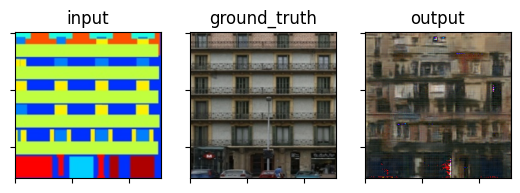

End of epoch 71 Time taken: 23.934406757354736
End of epoch 72 Time taken: 23.259784698486328
End of epoch 73 Time taken: 23.276170253753662
End of epoch 74 Time taken: 23.228291511535645
End of epoch 75 Time taken: 23.203062534332275
End of epoch 76 Time taken: 23.30596160888672
End of epoch 77 Time taken: 23.43316102027893
End of epoch 78 Time taken: 23.317194938659668
End of epoch 79 Time taken: 23.202792406082153
End of epoch 80 Time taken: 23.282281398773193
Epoch: 81


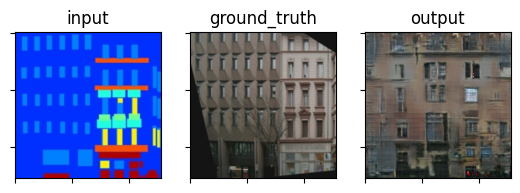

End of epoch 81 Time taken: 23.72130513191223
End of epoch 82 Time taken: 23.363603353500366
End of epoch 83 Time taken: 23.320659399032593
End of epoch 84 Time taken: 23.34315514564514
End of epoch 85 Time taken: 23.37220335006714
End of epoch 86 Time taken: 23.30125069618225
End of epoch 87 Time taken: 23.264384269714355
End of epoch 88 Time taken: 23.437453746795654
End of epoch 89 Time taken: 23.498658180236816
End of epoch 90 Time taken: 23.299904823303223
Epoch: 91


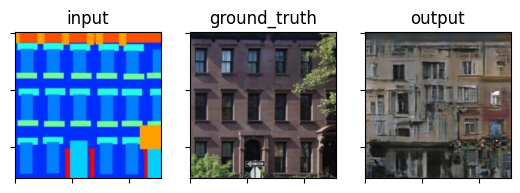

End of epoch 91 Time taken: 23.687151432037354
End of epoch 92 Time taken: 23.25733995437622
End of epoch 93 Time taken: 23.318153381347656
End of epoch 94 Time taken: 23.481306791305542
End of epoch 95 Time taken: 23.469805240631104
End of epoch 96 Time taken: 23.356589317321777
End of epoch 97 Time taken: 23.305551290512085
End of epoch 98 Time taken: 23.2894127368927
End of epoch 99 Time taken: 23.415491104125977
End of epoch 100 Time taken: 23.47742486000061
Epoch: 101


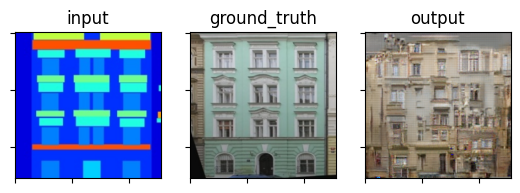

End of epoch 101 Time taken: 23.96137022972107
End of epoch 102 Time taken: 23.501779317855835
End of epoch 103 Time taken: 23.406527280807495
End of epoch 104 Time taken: 23.376144886016846
End of epoch 105 Time taken: 23.342141151428223
End of epoch 106 Time taken: 23.45498561859131
End of epoch 107 Time taken: 23.46756863594055
End of epoch 108 Time taken: 23.339887857437134
End of epoch 109 Time taken: 23.33849835395813
End of epoch 110 Time taken: 23.323477268218994
Epoch: 111


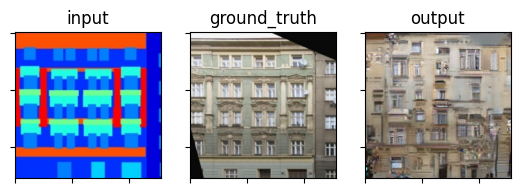

End of epoch 111 Time taken: 23.72372031211853
End of epoch 112 Time taken: 23.486400365829468
End of epoch 113 Time taken: 23.48906397819519
End of epoch 114 Time taken: 23.3828706741333
End of epoch 115 Time taken: 23.34856939315796
End of epoch 116 Time taken: 23.332098960876465
End of epoch 117 Time taken: 23.328142166137695
End of epoch 118 Time taken: 23.507728576660156
End of epoch 119 Time taken: 23.502039432525635
End of epoch 120 Time taken: 23.32973623275757
Epoch: 121


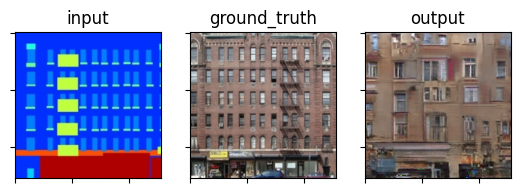

End of epoch 121 Time taken: 23.714699506759644
End of epoch 122 Time taken: 23.369991540908813
End of epoch 123 Time taken: 23.383081912994385
End of epoch 124 Time taken: 23.504377841949463
End of epoch 125 Time taken: 23.54388451576233
End of epoch 126 Time taken: 23.57506251335144
End of epoch 127 Time taken: 23.46449899673462
End of epoch 128 Time taken: 23.384376049041748
End of epoch 129 Time taken: 23.412561655044556
End of epoch 130 Time taken: 23.545763969421387
Epoch: 131


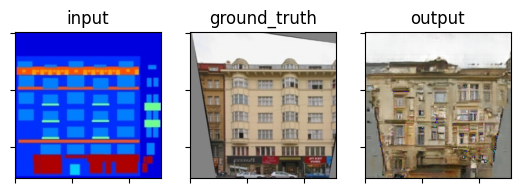

End of epoch 131 Time taken: 23.954365968704224
End of epoch 132 Time taken: 23.536646366119385
End of epoch 133 Time taken: 23.42177677154541
End of epoch 134 Time taken: 23.46577763557434
End of epoch 135 Time taken: 23.48764729499817
End of epoch 136 Time taken: 23.374359607696533
End of epoch 137 Time taken: 23.458933115005493
End of epoch 138 Time taken: 23.54905128479004
End of epoch 139 Time taken: 23.409090757369995
End of epoch 140 Time taken: 23.41686701774597
Epoch: 141


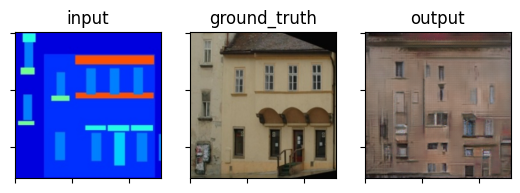

End of epoch 141 Time taken: 24.062706232070923
End of epoch 142 Time taken: 23.47961735725403
End of epoch 143 Time taken: 23.490286111831665
End of epoch 144 Time taken: 23.545777320861816
End of epoch 145 Time taken: 23.606584310531616
End of epoch 146 Time taken: 23.40956425666809
End of epoch 147 Time taken: 23.412288665771484
End of epoch 148 Time taken: 23.446125268936157
End of epoch 149 Time taken: 23.47549057006836
End of epoch 150 Time taken: 23.620968341827393
Epoch: 151


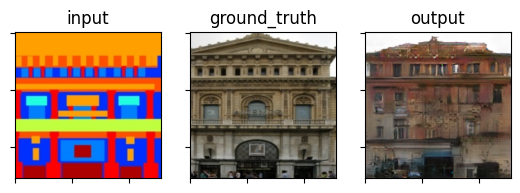

End of epoch 151 Time taken: 24.227760553359985
End of epoch 152 Time taken: 23.58868384361267
End of epoch 153 Time taken: 23.51803708076477
End of epoch 154 Time taken: 23.397831678390503
End of epoch 155 Time taken: 23.414572715759277
End of epoch 156 Time taken: 23.58876919746399
End of epoch 157 Time taken: 23.58414387702942
End of epoch 158 Time taken: 23.496803045272827
End of epoch 159 Time taken: 23.38744878768921
End of epoch 160 Time taken: 23.470078468322754
Epoch: 161


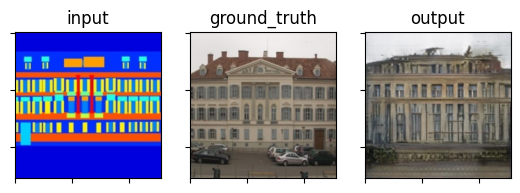

End of epoch 161 Time taken: 23.937224864959717
End of epoch 162 Time taken: 23.49606466293335
End of epoch 163 Time taken: 23.677988529205322
End of epoch 164 Time taken: 23.643328428268433
End of epoch 165 Time taken: 23.4266517162323
End of epoch 166 Time taken: 23.45284676551819
End of epoch 167 Time taken: 23.517229080200195
End of epoch 168 Time taken: 23.500007390975952
End of epoch 169 Time taken: 23.64245057106018
End of epoch 170 Time taken: 23.62350058555603
Epoch: 171


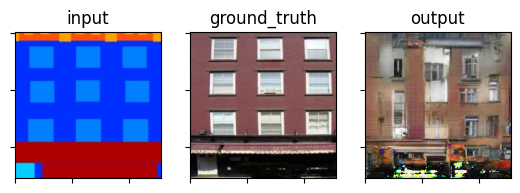

End of epoch 171 Time taken: 24.113154888153076
End of epoch 172 Time taken: 23.52280592918396
End of epoch 173 Time taken: 23.53743028640747
End of epoch 174 Time taken: 23.46443819999695
End of epoch 175 Time taken: 23.49301242828369
End of epoch 176 Time taken: 23.75312829017639
End of epoch 177 Time taken: 23.759861707687378
End of epoch 178 Time taken: 23.646856784820557
End of epoch 179 Time taken: 23.56278920173645
End of epoch 180 Time taken: 23.515802145004272
Epoch: 181


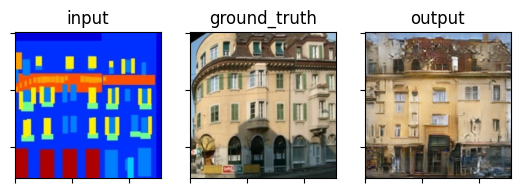

End of epoch 181 Time taken: 24.002450942993164
End of epoch 182 Time taken: 25.899203777313232
End of epoch 183 Time taken: 23.72688341140747
End of epoch 184 Time taken: 23.62215304374695
End of epoch 185 Time taken: 23.713326930999756
End of epoch 186 Time taken: 23.588353633880615
End of epoch 187 Time taken: 23.53770637512207
End of epoch 188 Time taken: 23.54529309272766
End of epoch 189 Time taken: 23.526813745498657
End of epoch 190 Time taken: 23.693665742874146
Epoch: 191


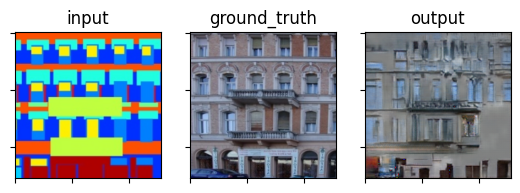

End of epoch 191 Time taken: 24.305619955062866
End of epoch 192 Time taken: 23.635664224624634
End of epoch 193 Time taken: 23.560134172439575
End of epoch 194 Time taken: 23.59802508354187
End of epoch 195 Time taken: 23.61233353614807
End of epoch 196 Time taken: 23.54662299156189
End of epoch 197 Time taken: 23.758260488510132
End of epoch 198 Time taken: 23.798211812973022
End of epoch 199 Time taken: 23.60885453224182
End of epoch 200 Time taken: 23.610724925994873


In [21]:
for epoch in range(epochs):
  start_time = time.time()
  epoch_gen_loss = 0.0
  epoch_disc_loss = 0.0
  for step, (inputs, targets) in enumerate(train_dataloader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    epoch_disc_loss += losses.train_discriminator_step(discriminator, generator, inputs, targets, disc_opt, device)
    gen_loss, generated_image = losses.generator_training_step(discriminator, generator, inputs, targets, gen_opt, device, L1_lambda = 100)
    epoch_gen_loss += gen_loss

    if(epoch % 10 == 0 and step == 0):
      print(f'Epoch: {epoch+1}')
      utils.print_sample(inputs[step], targets[step], generated_image)

  print(f'End of epoch {epoch+1} Time taken: {time.time() - start_time}')
  disc_losses.append(epoch_disc_loss / num_of_steps)
  gen_losses.append(epoch_gen_loss / num_of_steps)


In [22]:
!mkdir saved_models

In [23]:
torch.save(generator.state_dict(), 'saved_models/facades_generator_dict_100.pth')
torch.save(generator, 'saved_models/facades_generator_100.pth')
torch.save(discriminator.state_dict(), 'saved_models/facades_discriminator_dict_100.pth')
torch.save(discriminator, 'saved_models/facades_discriminator_100.pth')

In [24]:
discriminator_losses = list(map(lambda el: el.item(), disc_losses))
generator_losses = list(map(lambda el: el.item(), gen_losses))

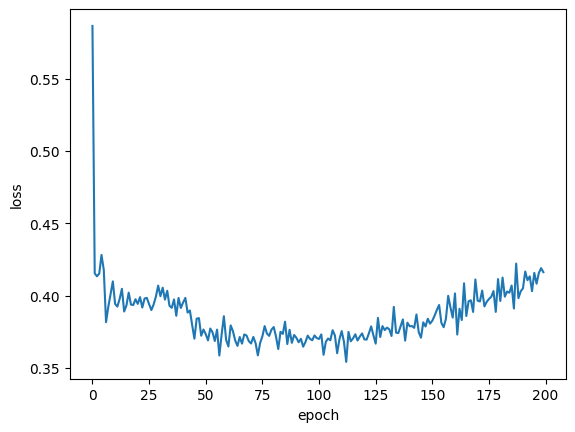

In [25]:
utils.plot_loss(discriminator_losses)

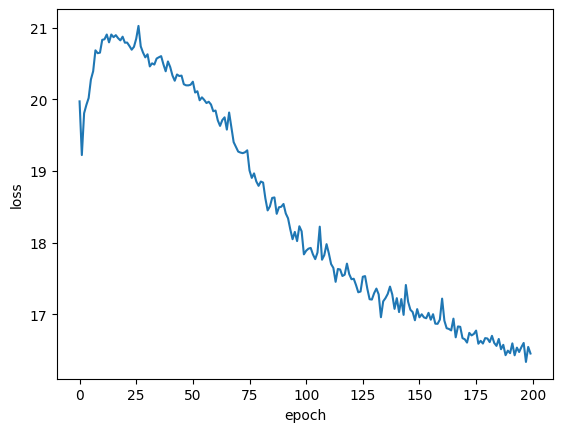

In [26]:
utils.plot_loss(generator_losses)

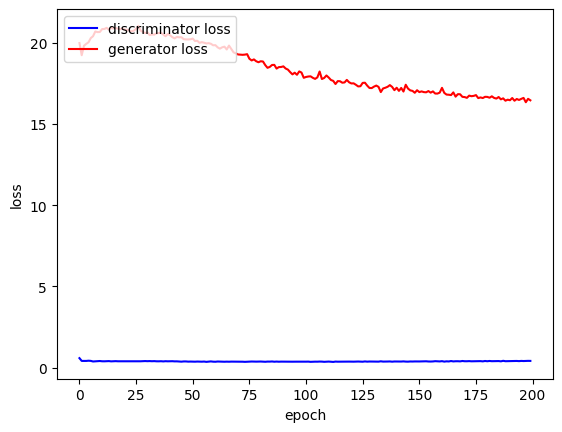

In [27]:
utils.plot_losses(discriminator_losses, generator_losses)

#Testing

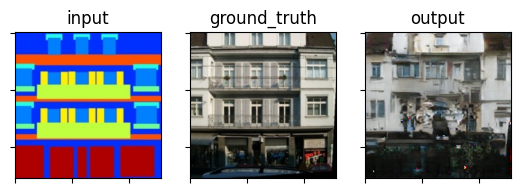

In [28]:
test_dataset = ImageDataset(pix2pix_dataset)
test_dataset.load_dataset()

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True, num_workers=num_threads)

inputs, targets = next(iter(test_dataloader))
gen = generator(inputs.to(device))

utils.print_sample(inputs[0], targets[0], gen)